In [1]:
import os
import sys
import time
import timeit
import traceback as tb
from pathlib import Path
import xarray as xr

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#DEBUG_FLAG = False

In [2]:
from HBV_setup import daa_optimize as HBVd_calib
from HBV_setup import dab_validate as HBVd_valid

## 1. Intoduction: The HBV Model and Ahr catchment

### Acknowledgement
We would like to thank Faizen Anwer from TU Munich for providing the HBV model used in this training school

### Display catchment
The cell below loads and plots a map of the two catchments and the sensor data. Frist the one for the official rain gauges from the DWD and the federal state of Rhineland-Palatinate. Both data sets are used for the operational interplation product (Intermet) which were used as input for the interpolation of the catchment precipitation time series. 

Text(0, 0.5, 'deg [°]')

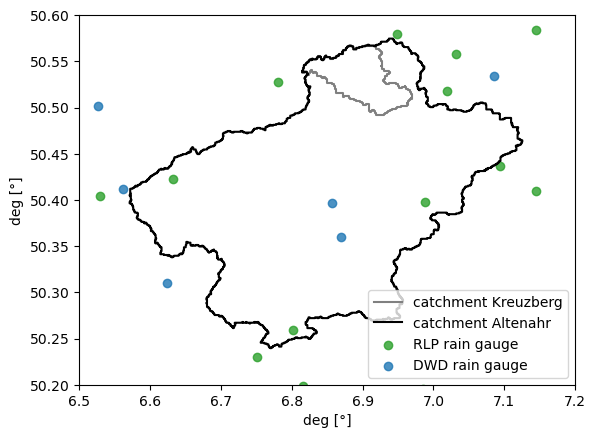

In [3]:
# load location of sensors:
df_pws = pd.read_csv("metadata/pws_coords.csv",sep=';')
df_dwd = pd.read_csv("metadata/dwd_coords.csv",sep=',')
df_rlp = pd.read_csv("metadata/coords_rlp.csv",sep=';')
df_altenahr_shape = pd.read_csv("metadata/Altenahr_shape.csv")
df_kreuzberg_shape = pd.read_csv("metadata/Kreuzberg_shape.csv")

# todo: -add the location of the stream gauges
#       -add rivers?
plt.plot(df_kreuzberg_shape.lon,df_kreuzberg_shape.lat,color='grey',label="catchment Kreuzberg")
plt.plot(df_altenahr_shape.lon,df_altenahr_shape.lat,color='black',label="catchment Altenahr")
plt.scatter(df_rlp.lon,df_rlp.lat,color='C2',label="RLP rain gauge", alpha=0.8)
plt.scatter(df_dwd.lon,df_dwd.lat,color='C0',label='DWD rain gauge',alpha=0.8)
plt.xlim(6.5,7.2)
plt.ylim(50.2,50.6)
plt.legend(loc='lower right')
plt.xlabel('deg [°]')
plt.ylabel('deg [°]')


### Question:
- How to you judge the coverage of rain gauges in these two catchments?

## 2. HBV modeling with daily data

Load daily HBV input data for calibration period from 2001 to 2011

### 2.1 Model Calibration

Calibration procedure involves following steps
- read calibration data
- set ranges for model parameters
- set catchment area 
- run optimization

#### Read calibration data

In [4]:
input_path = 'daily/inputs/daily_2001_2011/daily_input_data_10420.csv'
daily_data_calib_10420 = pd.read_csv(
    input_path, 
    sep=';', 
    index_col=0, 
    parse_dates=True)
daily_data_calib_10420

,dis_ref,ppt,tem,pet
2001-01-01,5.725000,3.099867,1.409078,0.224858
2001-01-02,9.134167,6.431726,6.913950,0.426405
2001-01-03,16.701042,1.194395,3.215183,0.338357
2001-01-04,15.762500,6.129237,4.829082,0.349561
2001-01-05,22.503125,21.276179,7.127980,0.396675
...,...,...,...,...
2010-12-28,7.041250,0.014050,-2.368453,0.000104
2010-12-29,6.321771,0.022779,-0.598562,0.119636
2010-12-30,5.746354,0.000000,-1.709442,0.005181
2010-12-31,5.340833,0.228312,-3.011018,0.031847


This is a function for plotting discharge and precipiation data. It takes a dataframe with preipitation and Discharge data as inputand you can specify the time spane by using `beg_time`and `end_time`

In [5]:
def plot_q_pcp(df, beg_time='2001-01-01', end_time='2021-01-01'):
    time = df[beg_time:end_time].index
    q = df.dis_ref[beg_time:end_time].values
    p = df[beg_time:end_time].ppt.values

    fig = plt.gcf()
    plt.clf()
    ax = plt.gca()

    ax.plot(time, q, color=[.5, .5, .5])
    ax.set_ylim([0, max(q) * 2])
    ax.set_ylabel('Q [m³/s]')
    ax.set_xlabel('time')

   # Rotate x-axis labels diagonally
    plt.xticks(rotation=45, ha='right')  # ha='right' aligns labels properly

    ax2 = ax.twinx()
    #ax2.bar(time, p, width=1, color=[0, .14, .5], edgecolor=[.7, .7, .7], alpha=.9, linewidth=.1)
    ax2.plot(time, p, color=[0, .14, .5], linestyle='-', linewidth=1.5, label="Precipitation (Pcp)")
    ax2.set_ylim([max(p) * 2, 0])
    ax2.set_ylabel('Pcp [mm / time_step]')
    
    plt.show(block=True)

You can modify the time span of displayed precipitation and runoff data.

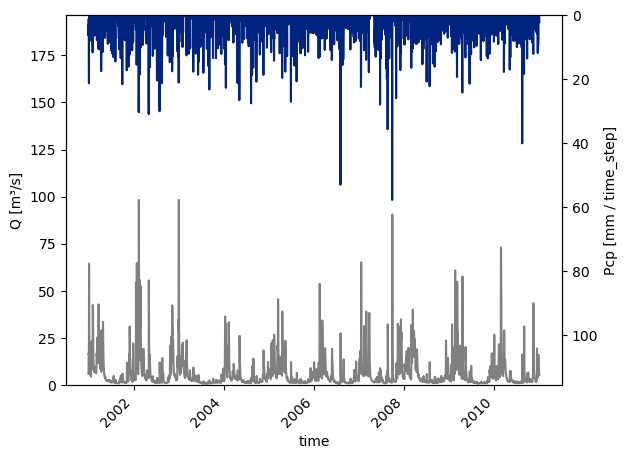

In [6]:
plot_q_pcp(daily_data_calib_10420, beg_time='2001-01-01', end_time='2021-01-01')

#### Set parameter bounds
Set upper and lower bounds for the model calibration (paramerter optimization). To save a computational time, we have fixed some of the parameter values in this exercise.

In [7]:
prms_buds_dict = {
    # snow storage parameters
    'snw_dth': (33.00, 33.00),  # Initial depth [L]
    'snw_ast': (-0.62, -0.62),  # Air snow TEM [K].
    'snw_amt': (-0.54, -0.54),  # Air melt TEM [K].
    'snw_amf': (1.9, 1.9),      # Air melt factor [L/TK].
    'snw_pmf': (0.65, 0.65),    # PPT melt factor [L/LTK].
    #soil storage parameters
    'sl0_mse': (5.66, 5.66),    # Soil 0 initial depth [L].
    'sl1_mse': (197.00, 197),   # Soil 1 initial depth [L].
    'sl0_fcy': (0.00, 2e+2),    # Field capacity [L].
    'sl0_bt0': (0.00, 3.00),    # Beta [-]. 
    'sl1_pwp': (0.00, 4e+2),    # PWP [L].
    'sl1_fcy': (0.00, 4e+2),    # Field capacity [L].
    'sl1_bt0': (2.5, 2.50),     # Beta [-].
    # uppper reservoir parameters
    'urr_dth': (6.1, 6.1),      # URR initial depth [L].
    'urr_rsr': (0.00, 1.00),    # Runoff split ratio [-].
    'urr_tdh': (0.00, 1e+2),    # Threshold depth [L].
    'urr_tdr': (0.00, 1.00),    # Threshold DIS const. [1/T].
    'urr_cst': (0.00, 1.00),    # RNF const. [1/T].
    'urr_dro': (0.00, 1.00),    # DIS ratio [-].
    'urr_ulc': (0.00, 1.00),    # URR-to-LRR const. [1/T].
    # lower reservoir data
    'lrr_dth': (1.14, 1.14),    # LRR initial depth [L].
    'lrr_tdh': (0.00, 1e+4),    # Threshold depth [L]
    'lrr_cst': (0.00, 1.00),    # Runoff const. [1/T].
    'lrr_dro': (0.00, 1.00),    # Discharge ratio [-].
    }

prms_long_names = {
    # snow storage parameters
    'snw_dth': "Initial depth (L)", 'snw_ast': "Air snow TEM (K)",
    'snw_amt': "Air melt TEM (K)", 'snw_amf': "Air melt factor (L/TK)",
    'snw_pmf': "PPT melt factor (L/LTK)",
    #soil storage parameters
    'sl0_mse': "Soil 0 initial depth (L)", 'sl1_mse': "Soil 1 initial depth (L)",
    'sl0_fcy': "Field capacity (L)",  'sl0_bt0': "Beta (-)",
    'sl1_pwp': "PWP (L)",  'sl1_fcy': "Field capacity (L)",
    'sl1_bt0': "Beta (-)",
    # uppper reservoir parameters
    'urr_dth': "URR initial depth (L)", 'urr_rsr': "Runoff split ratio (-)",
    'urr_tdh': "Threshold depth (L)", 'urr_tdr': "Threshold DIS const  (1/T)",
    'urr_cst': "RNF const  (1/T)", 'urr_dro': "DIS ratio (-)",
    'urr_ulc': "URR-to-LRR const  (1/T)", 
    # lower reservoir data
    'lrr_dth': "LRR initial depth (L)", 'lrr_tdh': "Threshold depth (L)",    # Threshold depth [L]
    'lrr_cst': "Runoff const  (1/T)", 'lrr_dro': "Discharge ratio (-)"
}

#### Model calibration
Feed the calibration function with:
- parameter dictionary
- input DataFrame
- catchment area
- output directory, where optimized parameters and other optimization outputs will be stored as csv files
- catchment label, string used in a name of the generated files

The following code will start the model calibration. Depending on the the Performance of your computer this may take several minutes.


In [8]:
c_area_10420 = 749117129.0 # catchment area in [m^2]
HBVd_calib.main(
    prms_buds_dict, 
    daily_data_calib_10420, 
    cat_area = c_area_10420, 
    output_dir=r'daily/calibration_hbv_daily', 
    cat_label = '10420')

Optimizing...
	Best model parameters:
snw_dth: 33.0 33.0 33.0
snw_ast: -0.62 -0.62 -0.62
snw_amt: -0.54 -0.54 -0.54
snw_amf: 1.9 1.9 1.9
snw_pmf: 0.65 0.65 0.65
sl0_mse: 5.66 5.66 5.66
sl1_mse: 197.0 197.0 197.0
sl0_fcy: 0.0 38.776604 200.0
sl0_bt0: 0.0 2.868935 3.0
sl1_pwp: 0.0 187.615446 400.0
sl1_fcy: 0.0 207.836152 400.0
sl1_bt0: 2.5 2.5 2.5
urr_dth: 6.1 6.1 6.1
lrr_dth: 1.14 1.14 1.14
urr_rsr: 0.0 0.941279 1.0
urr_tdh: 0.0 19.399101 100.0
urr_tdr: 0.0 0.29281 1.0
urr_cst: 0.0 0.216693 1.0
urr_dro: 0.0 0.856651 1.0
urr_ulc: 0.0 0.119657 1.0
lrr_tdh: 0.0 804.314262 10000.0
lrr_cst: 0.0 0.048735 1.0
lrr_dro: 0.0 0.787989 1.0

	Best objective function value: 0.152

	Total number of iterations: 76

	Time to optimize: 41.54 secs

	Final call to model time: 1.812E-02 secs



The results will be stored in a folder called `HBV/daily/calib_results_hbv_daily` (relative path in your working directory set above).
You will find here following files:
- "prms_{cat_label}_sr.csv" - optimized parameter values
- "prf_{cat_label}_sr.csv" - performance metrics
- "dis_sim_{cat_label}_df.csv" - simulated and reference flows
- "sim_{cat_label}_otps_df.csv" - simulated state variables

### Model performance during calibration
Let's read scores evaluating the model calibration and judge the model/calibration performance

In [9]:
daily_prf_calib_10420 = pd.read_csv(
    r'daily/calibration_hbv_daily/prf_10420_sr.csv', 
    sep=';', 
    skiprows = 1, 
    names = ['score', 'value'])

In [10]:
daily_prf_calib_10420

,score,value
0,OBJ,0.152026
1,NS,0.847974
2,LNS,0.326882
3,KG,0.910400
4,PC,0.922009
5,SC,0.934775


### Question: 
- How to you judge the Model performance based on Nash-Sutcliffe (NS) and above?

## 2.2. Model Validation

Now let's validate the model with data from 2011-2025

### Load model parameters and input data

Load the model parameters (optimized in the previous steps):

In [12]:
prms_path = Path(rf'daily/calibration_hbv_daily/prms_10420_sr.csv')
daily_prms_10420 = pd.read_csv(prms_path, sep=';', index_col=0).iloc[:, 0]

Load the input data for the validation period:

In [13]:
input_path = 'daily/inputs/daily_2011_2025/daily_input_data_10420.csv'
daily_data_valid_10420 = pd.read_csv(input_path, sep=';', index_col=0, parse_dates=True)
daily_data_valid_10420

,dis_ref,ppt,tem,pet
2011-01-01,5.346458,2.192507,0.368010,0.144146
2011-01-02,6.690521,1.630708,-0.769441,0.051401
2011-01-03,7.180000,0.604111,-1.932402,0.037025
2011-01-04,7.376979,0.000000,-4.063975,0.000239
2011-01-05,6.824896,3.314264,-4.864877,0.092951
...,...,...,...,...
2024-12-28,10.880208,0.000691,0.563647,0.301595
2024-12-29,9.383646,0.000000,-2.256746,0.001570
2024-12-30,8.091667,0.028412,-2.187375,0.031214
2024-12-31,7.207500,0.075611,-2.328958,0.041739


### Run the model validation

In [14]:
HBVd_valid.main(daily_prms_10420, daily_data_valid_10420, cat_area = c_area_10420, secs_per_step = 86400,
                output_dir=r'daily/validation_hbv_daily', cat_label = '10420')

	Final call to model time: 5.487E-02 secs



### Evaluate the model performance
load the performance scores:


In [15]:
# load performance scores
daily_prf_valid_10420 = pd.read_csv(
    r'daily/validation_hbv_daily/prf_10420_sr.csv', 
    sep=';', 
    skiprows = 1, 
    names = ['score', 'value'])
daily_prf_valid_10420

,score,value
0,OBJ,1.983241
1,NS,0.743340
2,LNS,-0.379600
3,KG,0.819775
4,PC,0.890888
5,SC,0.942356


Compare scores for the calibration and validation:

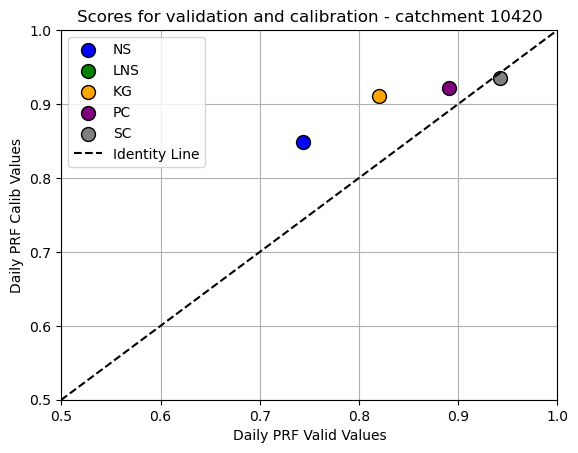

In [16]:
# Define colors and labels for each point
colors = ['red', 'blue', 'green', 'orange', 'purple', 'grey']
labels = daily_prf_valid_10420.score

# Create scatter plot
for i in range(1,6):
    plt.scatter(
        daily_prf_valid_10420.value[i], 
        daily_prf_calib_10420.value[i], 
        color=colors[i], label=labels[i], 
        edgecolors='k', s=100)

# Add identity line (y = x)
plt.plot([0,5], [0,5], linestyle='--', color='black', label="Identity Line")

# Set labels and title
plt.xlabel("Daily PRF Valid Values")
plt.ylabel("Daily PRF Calib Values")
plt.title("Scores for validation and calibration - catchment 10420")

# Add legend
plt.legend()

# Set axis limits to match the identity line range
plt.xlim(0.5, 1)
plt.ylim(0.5, 1)

# Show grid and plot
plt.grid(True)
plt.show()

### Question: 
- How to you judge the Model performance based on Nash-Sutcliffe (NS) above for the validation period?
- What could be the reasons that the NS worse?

### Compare simulated and reference flow time series
Plot the observed and simulatied discharges for the validation period 2016-2022 using the function below. You can adjust the time span by specifying start and end dates in .main(), e.g. (beg_time='2021-01-01',end_time='2022-01-01')

In [17]:
def plot_sim_ref_ts (dis_df, beg_time='2021-07-01', end_time='2021-08-01'):
    dis_df = dis_df.loc[beg_time:end_time,:]
    
    plt.plot(dis_df.index, dis_df['ref'].values, label='REF', alpha=0.8)
    plt.plot(dis_df.index, dis_df['sim'].values, label='SIM', alpha=0.8)
    
    plt.xlabel('Time [day]')
    plt.xticks(rotation=45, ha="right")
    plt.ylabel('Discharge [m$^3$.s$^{-1}$]')
    
    plt.grid()
    plt.gca().set_axisbelow(True)
    plt.legend()

This code loads simulated and reference data into a dataframe:

In [18]:
daily_sim_valid_10420 = pd.read_csv(
    r'daily/validation_hbv_daily/dis_sim_10420_df.csv', 
    sep=';', 
    index_col = 0)
daily_sim_valid_10420.index = pd.to_datetime(
    daily_sim_valid_10420.index, 
    format='%Y-%m-%d')
daily_sim_valid_10420

,ref,sim
2011-01-01,5.3,10.2
2011-01-02,6.7,7.4
2011-01-03,7.2,5.3
2011-01-04,7.4,4.0
2011-01-05,6.8,3.0
...,...,...
2024-12-28,10.9,6.8
2024-12-29,9.4,5.5
2024-12-30,8.1,4.5
2024-12-31,7.2,3.8


## Excercise 1:
Plot observed and simulated discharge in the variable `daily_sim_valid_10420` using the `plot_sim_ref_ts`function and explore differences during peak flows. You can also look at yearly flow maxima using e.g. this chunk of code to identify them: `peak_flow_dates = daily_sim_valid_10420.resample('YE')['ref'].apply(lambda x: x.idxmax())`


In [ ]:
plot_sim_ref_ts(daily_sim_valid_10420, beg_time='2015-07-01', end_time='2021-08-01')

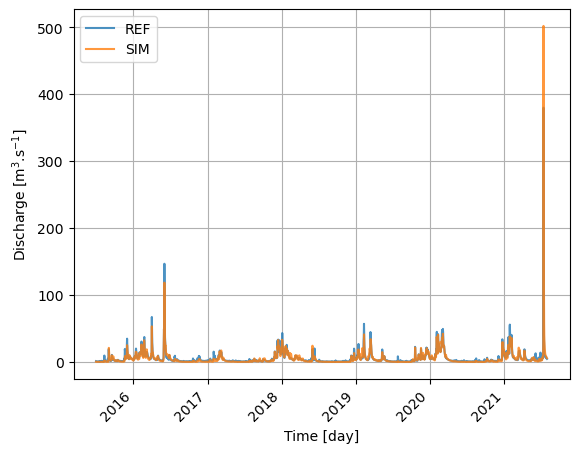

In [20]:
if input ("Enter 'Solution' to display solution: ") == 'Solution':
    %load solutions/1a_solution\ .py

In [25]:
if input ("Enter 'Solution' to display solution: ") == 'Solution':
    %load solutions/1b_solution.py

Enter 'Solution' to display solution:  Solution


In [26]:
# Identify dates of yearly flow maxima
peak_flow_dates = daily_sim_valid_10420.resample('YE')['ref'].apply(lambda x: x.idxmax())
daily_sim_valid_10420.loc[peak_flow_dates]

,ref,sim
2011-01-08,129.8,26.7
2012-01-06,60.1,49.2
2013-11-09,40.3,32.1
2014-08-27,52.5,28.8
2015-01-10,40.0,22.9
2016-06-02,146.6,118.4
2017-12-15,33.3,32.7
2018-01-04,43.1,32.2
2019-02-11,56.9,41.1
2020-03-06,49.3,42.0


### Question: 

-The peak discharge during the flood event in July 2021 at the gauge Altenahr was ~1200 m³/s. What is the issue here? 

**Hint:** Have a look at the hourly discharges between 14 and 16 July 2021 and plot these. The code below loads the hourly input data into a data frame, the observed discharge is named `hourly_ref`

Plot hourly and daily reference flows:

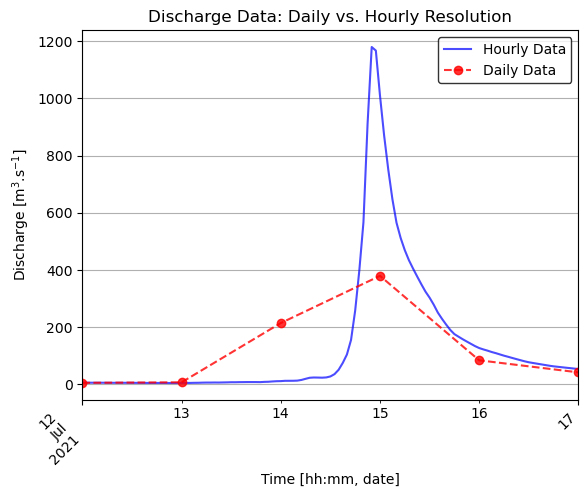

In [27]:
# read data
hourly_data_valid_10420=pd.read_csv(r'hourly/inputs/Intermet_gauge/hbv_input_data_10420.csv.zip',
                                    sep=';', index_col=0, parse_dates=True)

# Plot hourly data (blue line) and daily data (red dashed line with markers)
hourly_data_valid_10420.dis_ref['2021-07-12':'2021-07-17 00:00'].plot(
    label="Hourly Data", linestyle='-', color='blue', alpha=0.7)
daily_data_valid_10420.dis_ref['2021-07-12':'2021-07-17'].plot(
    label="Daily Data", linestyle='--', color='red', marker='o', alpha=0.8)

# Labels, titles 
plt.xlabel('Time [hh:mm, date]')
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
plt.ylabel('Discharge [m$^3$.s$^{-1}$]')
plt.title("Discharge Data: Daily vs. Hourly Resolution")

# Add legend with solid white background
plt.legend(facecolor='white', edgecolor='black')  # Edge color makes it visible
plt.grid(True) # Show grid

plt.show()

Compare hydrograph volumes:

In [28]:
hourly_volume = 3600 * sum(hourly_data_valid_10420.dis_ref['2021-07-12':'2021-07-17 00:00'].values[:1] + 
                                  hourly_data_valid_10420.dis_ref['2021-07-12':'2021-07-17 00:00'].values[:-1]) / 2
daily_volume = 3600 * 24 * sum(daily_data_valid_10420.dis_ref['2021-07-12':'2021-07-17'].values[:1] + 
                                      daily_data_valid_10420.dis_ref['2021-07-12':'2021-07-17'].values[:-1]) / 2
print(f"Hourly runoff volume in Mio m³: {round(1e-6 * hourly_volume, 2)}")
print(f"Dialy runoff volume in Mio m³: {round(1e-6 * daily_volume, 2)}")

Hourly runoff volume in Mio m³: 31.23
Dialy runoff volume in Mio m³: 31.08


### 3. HBV modeling with hourly data

As we've seen above, a daily model resolution is not suffcient to capture the flood peaks in smaller, fast reacting catchments. Before we investigate the influences of different (OS) rainfall inputs, we will look how the model works with standard (Intermet gauge) rainfall data at hourly resolution.

### 3.1 Model validation with hourly data

First we load the hourly data for the Altenahr catchment

In [29]:
input_path = 'hourly/inputs/Intermet_gauge/hbv_input_data_10420.csv.zip'
hourly_data_valid_10420 = pd.read_csv(input_path, sep=';', index_col=0, parse_dates=True)
hourly_data_valid_10420

,dis_ref,ppt,tem,pet
2001-01-01 00:00:00,5.87,0.0,-2.5,0.00
2001-01-01 01:00:00,5.73,0.0,-2.4,0.00
2001-01-01 02:00:00,5.73,0.0,-1.7,0.00
2001-01-01 03:00:00,5.73,0.0,-1.5,0.00
2001-01-01 04:00:00,5.73,0.0,-1.4,0.00
...,...,...,...,...
2022-12-31 19:00:00,11.40,0.0,12.5,0.01
2022-12-31 20:00:00,11.40,0.0,12.4,0.01
2022-12-31 21:00:00,11.40,0.0,12.1,0.01
2022-12-31 22:00:00,11.30,0.0,12.3,0.01


In [30]:
# Maximal reference flow rain
hourly_data_valid_10420.dis_ref.max()

1180.0

## Exercise 2
Use the `plot_q_pcp`function for plotting discharge and precipiation data. Plotting all hourly data might take some time, so consider specifying a time by using `beg_time`and `end_time`, e.g. for 2021

In [31]:
#type your code here:

In [35]:
if input("Enter 'Solution' to display solutions: ")=='Solution':
    %load solutions/2_solution.py

Enter 'Solution' to display solutions:  Solution


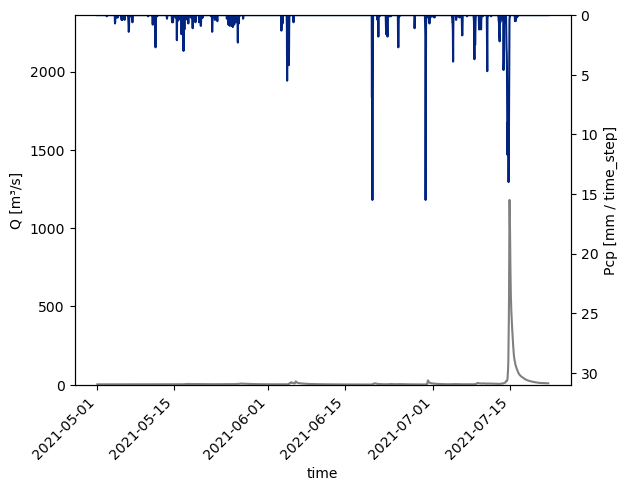

In [36]:
# %load solutions/3_1_1_solution.py
plot_q_pcp(hourly_data_valid_10420, beg_time='2021-05-01', end_time='2021-07-21')

### Question:
- What do you observe with respect to precipitation and discharge from May - August 2021?




## Run model with hourly data
Run model with hourly data. Use model parameters obtained in the previous exercise (calibration with daily data).   

In [37]:
HBVd_valid.main(daily_prms_10420, inp_dfe = hourly_data_valid_10420, cat_area = c_area_10420,
                secs_per_step = 3600, output_dir=r'hourly/validation_Intermet', cat_label = '10420')

	Final call to model time: 8.333E-01 secs



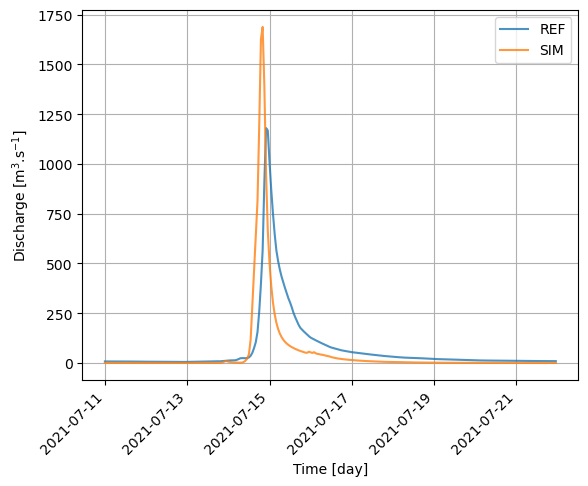

In [38]:
hourly_sim_valid_10420 = pd.read_csv(r'hourly/validation_Intermet/dis_sim_10420_df.csv', sep=';', index_col = 0)
hourly_sim_valid_10420.index = pd.to_datetime(hourly_sim_valid_10420.index, format='%Y-%m-%d %H:%M:%S')
#dis_df
plot_sim_ref_ts(hourly_sim_valid_10420, beg_time='2021-07-11', end_time='2021-07-21')

### Question
What ist the issue here? Why is the peak now overestimated?

### Run model with hourly data once again
We did calibration with hourly input data for you, so just load the optimized parameters and compare them with daily-data based parameters 


In [39]:
prms_path = Path(rf'hourly/calibration_Intermet_gauge/prms_10420_sr.csv')
hourly_prms_10420 = pd.read_csv(prms_path, sep=';', index_col=0).iloc[:, 0]

df = pd.concat([pd.Series(prms_long_names), daily_prms_10420, hourly_prms_10420], axis=1)
df.columns = ['Long names', 'Daily calibration', 'Hourly calibration']  # Rename columns if needed
df

,Long names,Daily calibration,Hourly calibration
snw_dth,Initial depth (L),33.000000,0.000000
snw_ast,Air snow TEM (K),-0.620000,1.382720
snw_amt,Air melt TEM (K),-0.540000,0.643190
snw_amf,Air melt factor (L/TK),1.900000,0.080340
snw_pmf,PPT melt factor (L/LTK),0.650000,0.568186
sl0_mse,Soil 0 initial depth (L),5.660000,45.936863
sl1_mse,Soil 1 initial depth (L),197.000000,185.826706
sl0_fcy,Field capacity (L),38.776604,29.404306
sl0_bt0,Beta (-),2.868935,1.825961
sl1_pwp,PWP (L),187.615448,209.902969


### Exercise 3
Run model again with parameters optimized on hourly Intermet interploated gauge data. They are stored now in `hourly_prms_10420`

In [41]:
if input("Enter 'Solution' to display solutions: ")=='Solution':
    %load solutions/3_solution.py

Enter 'Solution' to display solutions:  Solution


In [42]:
c_area = 749.1 * 1e6
HBVd_valid.main(
    hourly_prms_10420, 
    inp_dfe = hourly_data_valid_10420, 
    cat_area = c_area,
    secs_per_step = 3600, 
    output_dir=r'hourly/validation_Intermet', 
    cat_label = '10420')

	Final call to model time: 9.124E-01 secs



In [44]:
hourly_prf_valid_10420_new = pd.read_csv(
    r'hourly/validation_Intermet/prf_10420_sr.csv', 
    sep=';')

In [45]:
hourly_prf_valid_10420_new

,Unnamed: 0,0
0,OBJ,1.989094
1,NS,0.893541
2,LNS,-0.656384
3,KG,0.900341
4,PC,0.946094
5,SC,0.927314


### Plot simulation with hourly data

In [47]:
# store old simluation into a separate variable
hourly_sim_valid_10420_new = pd.read_csv(
    r'hourly/validation_Intermet/dis_sim_10420_df.csv', 
    sep=';', 
    index_col = 0)
hourly_sim_valid_10420_new.index = pd.to_datetime(
    hourly_sim_valid_10420_new.index, 
    format='%Y-%m-%d %H:%M:%S')

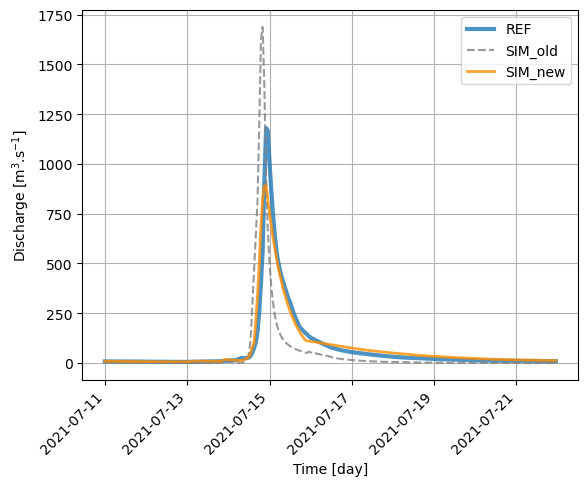

In [48]:
ts_old = hourly_sim_valid_10420['2021-07-11':'2021-07-21']
ts_new = hourly_sim_valid_10420_new['2021-07-11':'2021-07-21']

plt.plot(ts_old.index, ts_old['ref'].values, label = 'REF', alpha = 0.8, lw = 3)
plt.plot(ts_old.index, ts_old['sim'].values, label = 'SIM_old', alpha = 0.8, color = 'grey', ls = '--')
plt.plot(ts_new.index, ts_new['sim'].values, label = 'SIM_new', alpha = 0.8, color = 'darkorange', lw = 2)


plt.xlabel('Time [day]')
plt.xticks(rotation=45, ha="right")
plt.ylabel('Discharge [m$^3$.s$^{-1}$]')

plt.grid()
plt.gca().set_axisbelow(True)
plt.legend()

### 3.2 Rainfall from OS Sensors

The following code will plot a map showing the location of PWS(and CMLs?) together with the DWD and RLP rain guages

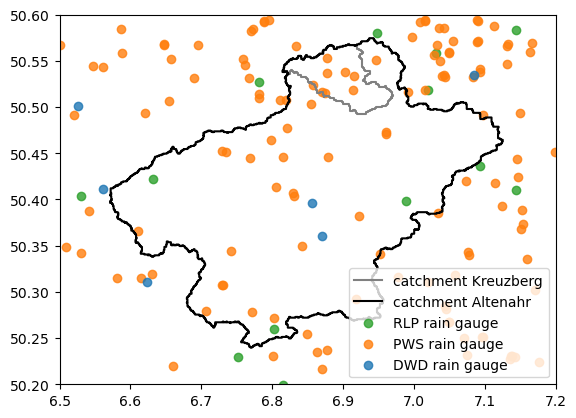

In [49]:
plt.plot(df_kreuzberg_shape.lon,df_kreuzberg_shape.lat,color='grey',label="catchment Kreuzberg")
plt.plot(df_altenahr_shape.lon,df_altenahr_shape.lat,color='black',label="catchment Altenahr")
plt.scatter(df_rlp.lon,df_rlp.lat,color='C2',label="RLP rain gauge", alpha=0.8)
plt.scatter(df_pws.lon,df_pws.lat,color='C1',label="PWS rain gauge",alpha=0.8)
plt.scatter(df_dwd.lon,df_dwd.lat,color='C0',label='DWD rain gauge',alpha=0.8)
plt.xlim(6.5,7.2)
plt.ylim(50.2,50.6)
plt.legend(loc='lower right')

<img src="solutions/os_map.png" alt="Description" style="width:600px;">

Now we compare the different precipitation datasets (official and OS) for the event itself which was on 14/15 July 2021. First for the Altenahr catchment. The following precipitation datasets are available for the two catachments {ID}:
- `Intermet`: Interpolated DWD and RLP gauge data
- `RW_cml`: CML adjusted radar data
- `RW_gauge`: gauge adjusted radar data
- `RW_gauge_cml`: CML and gauge adjusted radar data
- `dwd`: Interpolation from DWD rain gauges
- `dwd_pws`: Interpolation from DWD rain gauges and PWS
- `dwd_pws_cml`: Interpolation from DWD rain gauges, PWS and CML

Task: load and plot the different data sets for the two catchments. The data are located in the folder `/data/OS_pcp`

#### Altenahr (ID: 10420)

In [50]:
os_pcp_10420=pd.read_csv(r'hourly/OS_pcp/os_pcp_10420.csv', sep=';', index_col=0, parse_dates=True)

<Axes: >

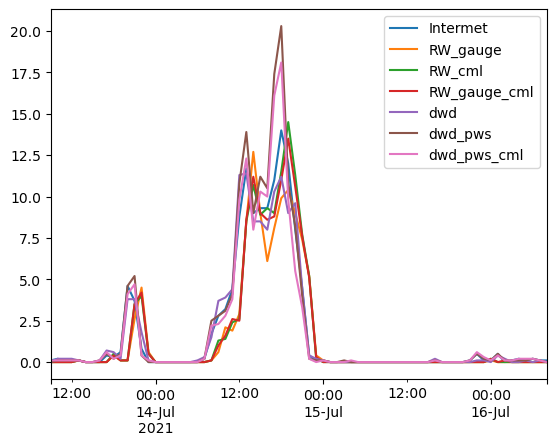

In [51]:
os_pcp_10420.plot()

#### Kreuzberg (ID: 10460)

<Axes: >

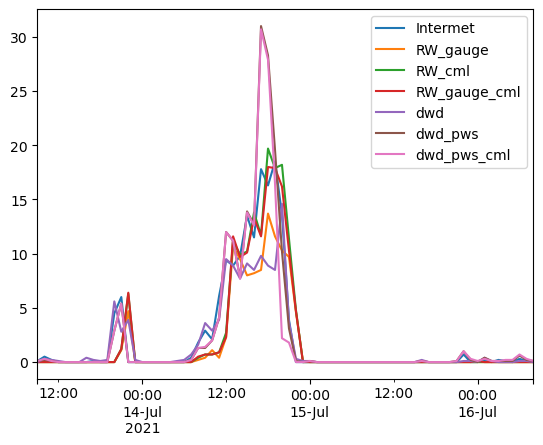

In [52]:
os_pcp_10460=pd.read_csv(r'hourly/OS_pcp/os_pcp_10460.csv', sep=';', index_col=0, parse_dates=True)
os_pcp_10460.plot()

* Question: What do you observe here?

### 3.3 Running the model with OS data

We will now run the model with different rainfall inputs. Tempreture and PET is always the same. THe files with modified precipitation data are in the folders Inputs and subfoders 
- `Intermet_gauge`: Interpolated DWD and RLP gauge data
- `RW_cml`: CML adjusted radar data
- `RW_gauge`: gauge adjusted radar data
- `RW_gauge_cml`: CML and gauge adjusted radar data
- `dwd`: Interpolation from DWD rain gauges
- `dwd_pws`: Interpolation from DWD rain gauges and PWS
- `dwd_pws_cml`: Interpolation from DWD rain gauges, PWS and CML

# Exercise 4
- Modify string in dataset variable to match the folder names with different rainfall inputs (above) and run the validation.
in the cells below, compare the time series.
- Run the simulation for Kreuzberg catchment

In [54]:
dataset = 'dwd_pws'
input_dir_name = r'hourly/inputs/' + dataset
output_dir_name = r'hourly/validation_' + dataset

ID='10420'
hourly_valid_10420 = pd.read_csv(input_dir_name + '/hbv_input_data_' + ID + '.csv.zip', sep=';',
                                          index_col=0, parse_dates=True)
c_area_10420 = 749117129.0 # area of the catchment in m2
HBVd_valid.main(hourly_prms_10420, hourly_valid_10420, cat_area = c_area_10420, secs_per_step = 3600,
                output_dir = output_dir_name, cat_label = ID)


	Final call to model time: 8.651E-01 secs



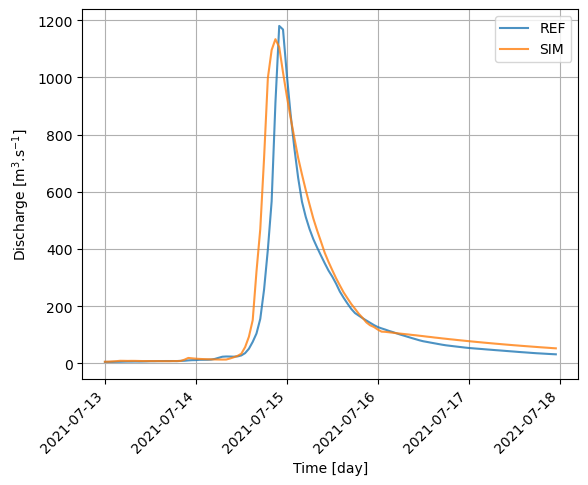

In [55]:
hourly_sim_valid_10420 = pd.read_csv(output_dir_name + '/dis_sim_10420_df.csv', sep=';', index_col = 0)
hourly_sim_valid_10420.index = pd.to_datetime(hourly_sim_valid_10420.index, format='%Y-%m-%d %H:%M:%S')
#dis_df
plot_sim_ref_ts(hourly_sim_valid_10420, beg_time='2021-07-13', end_time='2021-07-17')

### Kreuzberg catchment simulation
Use the different OS precipitation data for the Kreuzberg Catchment as done above by changing the `dataset`

In [56]:
c_area_10460 = 45117129.0 # catchment area in [m^2]
prms_path = Path(rf'hourly/calibration_Intermet_gauge/prms_10460_sr.csv')
hourly_prms_10460 = pd.read_csv(prms_path, sep=';', index_col=0).iloc[:, 0]

In [57]:
dataset = 'Intermet_gauge'
input_dir_name = r'hourly/inputs/' + dataset
output_dir_name = r'hourly/validation_' + dataset

ID = '10460'
hourly_valid_10460 = pd.read_csv(input_dir_name + '/hbv_input_data_' + ID + '.csv.zip',
                                 sep=';', index_col=0, parse_dates=True)
c_area_10460 = 45*1e6 # area of the catchment in m2
hourly_valid_10460['dis_ref'] = hourly_valid_10460['dis_ref'] + 0.001

HBVd_valid.main(hourly_prms_10460, hourly_valid_10460, cat_area = c_area_10460, secs_per_step = 3600,
                output_dir = output_dir_name, cat_label = ID)


#min(hourly_RW_gauge_valid_10460['dis_ref'])
#HBVd_valid.main(main_dir=path, ID=ID, dir_name=dir_name)

	Final call to model time: 8.684E-01 secs



In [58]:
dataset = 'Intermet_gauge'
input_dir_name = r'hourly/inputs/' + dataset
output_dir_name = r'hourly/validation_' + dataset

ID = '10460'
hourly_valid_10460 = pd.read_csv(input_dir_name + '/hbv_input_data_' + ID + '.csv', sep=';', index_col=0, parse_dates=True)
c_area = 45*1e6 # area of the catchment in m2
hourly_valid_10460['dis_ref'] = hourly_valid_10460['dis_ref'] + 0.001

HBVd_valid.main(hourly_prms_10460, hourly_valid_10460, cat_area = c_area, secs_per_step = 3600,
                output_dir = output_dir_name, cat_label = ID)


#min(hourly_RW_gauge_valid_10460['dis_ref'])
#HBVd_valid.main(main_dir=path, ID=ID, dir_name=dir_name)

FileNotFoundError: [Errno 2] No such file or directory: 'hourly/inputs/Intermet_gauge/hbv_input_data_10460.csv'

In [ ]:
hourly_sim_valid_10460 = pd.read_csv(output_dir_name + '/dis_sim_10460_df.csv', sep=';', index_col = 0)
hourly_sim_valid_10460.index = pd.to_datetime(hourly_sim_valid_10460.index, format='%Y-%m-%d %H:%M:%S')

#dis_df
plot_sim_ref_ts(hourly_sim_valid_10460, beg_time='2021-07-13', end_time='2021-07-17')

## Question
- What do you observe when you use different datasets for the model?
- Why are results not always optimal?

### 3.4 Spatial patterns of different OS precipitation data sets

As a final exercise we can look at and comapre the spatial rainfall data from different precipitation datasets. You will find all the data sets as netCDF files in the folder `hourly/OS_PCP`. These datasets contain data from xxx to xxx and are as follows:
- `dwd.nc` : Interpolated rainfall from DWD and RLP rain gauges
- `dwd_pws.nc` : Interpolated rainfall from DWD,RLP and QC'ed PWS
- `dwd_pws_cml.nc` : Interpolated rainfall from DWD,RLP and QC'ed PWS and CML
- `RW_gauge.nc` : Gauge adjusted radar data
- `RW_cml.nc` : CML adjusted radar data
- `RW_gauge_cml.nc` : Gauge and CML adjusted radar data

Here's an example how you can load and explore these data:

In [59]:
# load RW_cml data set
ds_RW_cml=xr.open_dataset(r'hourly/OS_pcp/RW_cml.nc')
ds_dwd_pws=xr.open_dataset(r'hourly/OS_pcp/dwd_pws.nc')

In [60]:
ds_RW_cml

<xarray.Dataset> Size: 2MB
Dimensions:     (time: 72, y: 50, x: 55)
Coordinates:
  * x           (x) float64 440B -262.5 -261.5 -260.5 ... -210.5 -209.5 -208.5
  * y           (y) float64 400B -4.298e+03 -4.297e+03 ... -4.25e+03 -4.249e+03
    latitudes   (y, x) float64 22kB ...
    longitudes  (y, x) float64 22kB ...
  * time        (time) datetime64[ns] 576B 2021-07-13T06:50:00 ... 2021-07-16...
Data variables:
    RW          (time, y, x) float64 2MB ...

Plot maps and explore the data and spatial patterns. The variable in the RW datasets is called `RW`, in the dwd datsets `rainfall`. You have several options:
 - plot a time step, e.g. (`isel(time=30)`) 
 - plot the sum for the whole time by using `sum(dim='time')`
 - by adding `plot(x='longitudes', y='latitudes')`you can plot the map with Lat/Lon coordinates
 - you can also plot difference maps by substracating two datasats

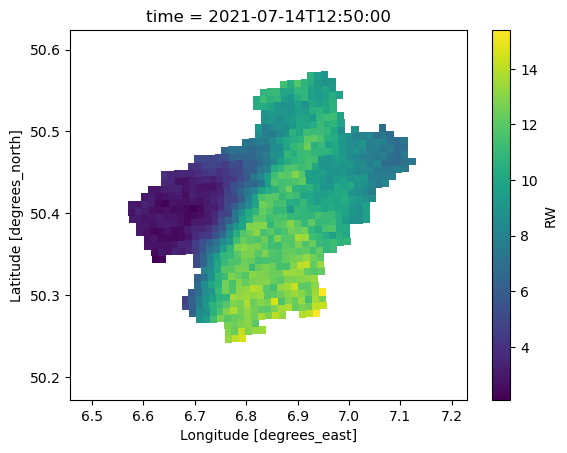

In [61]:
# plot a map with the data for the first time step (isel(time=30)). The variable is called 'RW'
ds_RW_cml.isel(time=30).RW.plot(x='longitudes', y='latitudes')

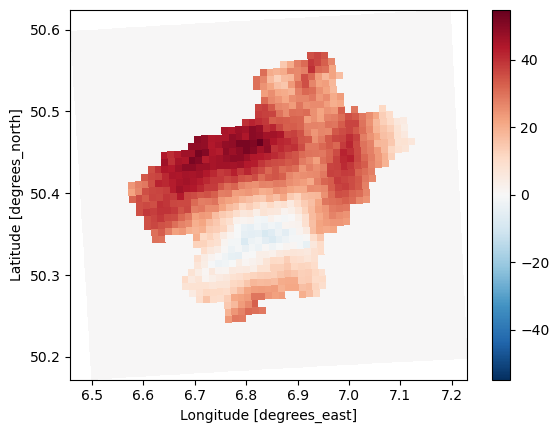

In [62]:
(ds_dwd_pws.rainfall[24:41].sum(dim='time')-ds_RW_cml.RW[24:41].sum(dim='time')).plot(x='longitudes', y='latitudes')

